# Get lyrics for evaluation

In [3]:
# IMPORTS
import fasttext
import fasttext.util
import math
import pandas as pd
import numpy as np
np.random.seed(42)

import sys
sys.path.append('../match-api/')
from utils.text_processing import stopwords, normalize, tokenize_text
from utils.lyrics_expansion import get_word_vectors, load_precomputed_similar_words, expand_query, fasttext_exact_nn

In [4]:
# GET RANDOM SUBSET OF WORDS TO EVALUATE LYRICS SEARCH
# Load the fasttext model
ft = fasttext.load_model('../match-api/models/cc.en.300.bin')

# Words in ft are ordered by frequency, but frequency is not given
words = ft.get_words()
# Only keep lowercase, alphanumeric words that are not stopwords
words = [word for word in words if (word.islower() & word.isalnum() & (word not in stopwords))]  # Only keep lowercase, alphanumeric words


# Use Zipf's law to simulate word probabilities
ranks = np.arange(1, len(words) + 1)  # Rank from 1 to 2 million
probabilities = 1 / ranks  # Probability ∝ 1/rank
probabilities /= probabilities.sum()  # Normalize to sum to 1

# Sample 3 words from the vocabulary weighted by frequency
lyrics_queries = []
for i in range(10):
    # Sample 3 words based on their probability distribution
    sampled_words = np.random.choice(words, size=3, p=probabilities, replace=False)
    lyrics_queries.append({'query': ", ".join(sampled_words)})

In [5]:
# SHOW EXPANDED QUERIES

# Paths
lyrics_precomputed_similar_path = '../match-api/data/stored_data/precomputed_similar_stems_lyrics.pkl'
lyrics_5000_stems_path = '../match-api/data/stored_data/lyrics_5000_stems.txt'

# Load the 5000 lyrics stems
with open(lyrics_5000_stems_path, 'r') as file:
    lyrics_5000_stems = {stem.strip() for stem in file.readlines()}

# Load precomputed similar words
precomputed_similar_words = load_precomputed_similar_words(lyrics_precomputed_similar_path)

# Get the word vectors for the lyrics words
lyrics_words = list(precomputed_similar_words.keys())
lyrics_vectors = get_word_vectors(lyrics_words, ft)
lyrics_word_map = {i: word for i, word in enumerate(lyrics_words)}

def expand_query(query: str, ft, precomputed_similar_words, lyrics_vectors, lyrics_word_map, lyrics_5000_stems, threshold=0.7, k=20):
    """
    Expands a query by using precomputed similar words when available, 
    and falling back to exact cosine similarity for unseen words.
    """
    # Tokenize, remove stopwords, and get unique words
    words = tokenize_text(query)
    stems = normalize(words)

    extended_tokens = []

    for word, stem in zip(words, stems):

        # Ignore stopwords
        if word in stopwords:
            continue

        # Do not extend common words
        if word in precomputed_similar_words:
            extended_tokens.append(stem)
            continue

        # Get the top similar word, if above the threshold
        similar_words = fasttext_exact_nn(word, lyrics_vectors, lyrics_word_map, ft, k=k, threshold=threshold)
        similar_stems = normalize(similar_words)[:1] + [stem]
        
        # Add to the query only if the stem is in the 5000 top-stems
        extended_tokens.extend([stem for stem in similar_stems if stem in lyrics_5000_stems])

    return extended_tokens

for query in lyrics_queries:
    expanded_query = expand_query(query['query'], ft, precomputed_similar_words, lyrics_vectors, lyrics_word_map, lyrics_5000_stems, k=10, threshold=0.6)
    print(query['query'], "->", expanded_query)

won, illidan, strands -> ['won', 'sheep', 'strand']
unable, years, time -> ['unabl', 'year', 'time']
energise, frequently, barrels -> ['often', 'barrel']
time, 53x, specular -> ['time']
year, work, don -> ['year', 'work', 'don']
business, characters, question -> ['busi', 'question']
game, singer, good -> ['game', 'singer', 'good']
days, change, range -> ['day', 'chang', 'rang']
isle, back, places -> ['island', 'back', 'place']
menu, time, chair -> ['time', 'chair']


The previous queries were provided to the search engine, and results were saved in `lyrics_results.txt`.

In [6]:
# GET PROMPTS FOR CHATGPT
with open('data/lyrics_results.txt', 'r') as f:
    results = {}
    for l in f:
        l = l.strip()
        if l.startswith('query'):
            query = l.split('|')[1]
            results[query] = []
        elif l.startswith('Song'):
            rows = l.split('|')
            results[query].append(rows[1:4])


Prompt1 = '''\
Search for the lyrics of the following five songs and explain what each song is about. 
If you cannot find the lyrics for a song, first try this website: https://genius.com/
If you still cannot find them, provide the title and author of the song/s you can't find at the end of your response so I can provide them manually
'''
Prompt2 = f'''\
Given the query below, rank each of the previously analyzed songs on a scale from 0 to 4 based on how relevant the song is to the query. Use the following ranking system:
4 - Perfect
3 - Excellent
2 - Good
1 - Fair
0 - Bad

First, provide a table with the song title and ranking. After that, explain why you gave each ranking.
Keep the same order in which the songs are provided:'''

for query, vals in results.items():
    for val_batch in [vals[:5], vals[5:]]:
        print(Prompt1)
        for val in val_batch:
            print(" | ".join(val[1:]))
        print('----------------')
        print(Prompt2)
        for val in val_batch:
            print(" | ".join(val[1:]))
        print("Query:", query)
        print('----------------')
        print('----------------')

Search for the lyrics of the following five songs and explain what each song is about. 
If you cannot find the lyrics for a song, first try this website: https://genius.com/
If you still cannot find them, provide the title and author of the song/s you can't find at the end of your response so I can provide them manually

Troumland | Kisha
Black Sheep | SONATA ARCTICA
Solitaire Unraveling | Mushroomhead
This Is My Favorite Cage | Joe Henry
Human & Human | Pipedown
----------------
Given the query below, rank each of the previously analyzed songs on a scale from 0 to 4 based on how relevant the song is to the query. Use the following ranking system:
4 - Perfect
3 - Excellent
2 - Good
1 - Fair
0 - Bad

First, provide a table with the song title and ranking. After that, explain why you gave each ranking.
Keep the same order in which the songs are provided:
Troumland | Kisha
Black Sheep | SONATA ARCTICA
Solitaire Unraveling | Mushroomhead
This Is My Favorite Cage | Joe Henry
Human & Human |

In [7]:
# Convert the unstructured lyrics results.txt into a structured tsv file
with open('data/lyrics_results.txt', 'r') as f:
    results = {}
    for l in f:
        l = l.strip()
        if l.startswith('query'):
            query = l.split('|')[1]
        elif l.startswith('Song'):
            rows = l.split('|')
            results[query+rows[0]] = {
                'query': query,
                'rank': rows[0].replace("Song", ""),
                'id': rows[1],
                'title': rows[2],
                'artist': rows[3],
                'album': rows[4],
                'score': rows[5]
            }

lyrics_results = pd.DataFrame(results).T
lyrics_results.to_csv('data/lyrics_results.tsv', sep='\t', index=False)

# Evaluate lyrics results

In [1]:
import math
import pandas as pd
import numpy as np
np.random.seed(42)

# Get lyrics evaluation as a dictionary
lyrics_results = pd.read_csv('data/lyrics_results.tsv', sep='\t')

# Convert DataFrame to dictionary where keys are queries and values are lists of scores
lyrics_evaluation = lyrics_results.groupby('query')['score'].apply(list).to_dict()
lyrics_evaluation

{'business, characters, question': [4, 2, 1, 4, 3, 2, 3, 1, 3, 4],
 'days, change, range': [2, 4, 2, 3, 3, 4, 1, 2, 4, 3],
 'energise, frequently, barrels': [2, 3, 1, 2, 0, 2, 3, 3, 1, 2],
 'game, singer, good': [3, 4, 4, 3, 1, 2, 4, 3, 1, 3],
 'isle, back, places': [4, 1, 2, 2, 4, 4, 2, 3, 4, 4],
 'menu, time, chair': [2, 1, 4, 4, 3, 2, 3, 4, 2, 3],
 'time, 53x, specular': [3, 4, 4, 3, 2, 4, 3, 4, 4, 3],
 'unable, years, time': [2, 4, 2, 3, 3, 2, 4, 3, 4, 1],
 'won, illidan, strands': [0, 2, 3, 2, 1, 3, 4, 1, 0, 1],
 'year, work, don': [4, 3, 2, 1, 2, 4, 3, 2, 2, 1]}

In [2]:
# EVALUATE
def precision_at_k(relevance_scores, k, relevance_threshold=1):
    """Calculate precision at k using a relevance threshold"""
    if k <= 0 or not relevance_scores:
        return 0.0
    # Count documents with relevance score >= threshold
    relevant_count = sum(1 for score in relevance_scores[:k] if score >= relevance_threshold)
    return relevant_count / k

def dcg_at_k(relevance_scores, k):
    """Calculate DCG at k"""
    if not relevance_scores:
        return 0.0
    dcg = relevance_scores[0] 
    for i in range(1, min(k, len(relevance_scores))):
        dcg += relevance_scores[i] / math.log2(i + 2)
    return dcg

def ndcg_at_k(relevance_scores, k):
    """Calculate nDCG at k"""
    dcg = dcg_at_k(relevance_scores, k)
    ideal_scores = sorted(relevance_scores[:k], reverse=True)
    idcg = dcg_at_k(ideal_scores, k)
    return dcg / idcg if idcg > 0 else 0

def mrr(relevance_scores, relevance_threshold=1):
    """Calculate Mean Reciprocal Rank"""
    for i, score in enumerate(relevance_scores):
        if score >= relevance_threshold:
            return 1.0 / (i + 1)
    return 0.0

def average_rating(relevance_scores, k=10):
    """Calculate average relevance score"""
    if not relevance_scores:
        return 0.0
    return sum(relevance_scores[:k]) / min(k, len(relevance_scores))

def calculate_all_metrics(relevance_scores):
    """Calculate all metrics for a single query's relevance scores"""
    metrics = {
        'P@5': precision_at_k(relevance_scores, 5, relevance_threshold=2),
        'P@10': precision_at_k(relevance_scores, 10, relevance_threshold=2),
        'nDCG@5': ndcg_at_k(relevance_scores, 5),
        'nDCG@10': ndcg_at_k(relevance_scores, 10),
        'MRR': mrr(relevance_scores, relevance_threshold=3),
        'Avg Rating': average_rating(relevance_scores)
    }
    return {k: round(v, 3) for k, v in metrics.items()}

def evaluate_rankings(query_relevance_dict):
    """
    Evaluate a set of ranking results and return a DataFrame with metrics.
    
    Parameters:
    -----------
    query_relevance_dict : dict
        Dictionary where keys are query identifiers and values are lists of relevance scores
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing evaluation metrics for each query and an average row
    """
    # Create results list with metrics for each query
    results = []
    for query, relevance_scores in query_relevance_dict.items():
        # Calculate all metrics for this query
        result = calculate_all_metrics(relevance_scores)
        result['Query'] = query
        results.append(result)

    # Create DataFrame
    df_results = pd.DataFrame(results)
    
    # If no results, return empty DataFrame
    if df_results.empty:
        return df_results
        
    # Define the column order
    columns = ['Query', 'P@5', 'P@10', 'nDCG@5', 'nDCG@10', 'MRR', 'Avg Rating']
    df_results = df_results[columns]

    # Calculate summary with mean of each metric
    summary = {'Query': 'Average'}
    for col in columns[1:]:  # Skip 'Query' column
        summary[col] = round(df_results[col].mean(), 3)

    # Add summary row and return the complete table
    df_complete = pd.concat([df_results, pd.DataFrame([summary])], ignore_index=True)
    return df_complete

# Example usage
df = evaluate_rankings(lyrics_evaluation)
display(df)  # or just 'df' in a notebook cell

,Query,P@5,P@10,nDCG@5,nDCG@10,MRR,Avg Rating
0,"business, characters, question",0.80,0.80,0.932,0.914,1.000,2.70
1,"days, change, range",1.00,0.90,0.884,0.874,0.500,2.80
2,"energise, frequently, barrels",0.60,0.70,0.923,0.877,0.500,1.90
3,"game, singer, good",0.80,0.80,0.948,0.937,1.000,2.80
4,"isle, back, places",0.80,0.90,0.917,0.893,1.000,3.00
5,"menu, time, chair",0.80,0.90,0.810,0.840,0.333,2.80
6,"time, 53x, specular",1.00,1.00,0.950,0.942,1.000,3.40
7,"unable, years, time",1.00,0.90,0.884,0.876,0.500,2.80
8,"won, illidan, strands",0.60,0.50,0.704,0.699,0.333,1.70
9,"year, work, don",0.80,0.80,0.995,0.949,1.000,2.40


# Evaluate retrieval time

In [10]:
# Generate queries of different lengths for evaluation
def generate_test_queries(num_queries_per_length=3):
    test_queries = []
    
    # Test various query lengths
    for length in [1,3,5,10,15]:
        for _ in range(num_queries_per_length):
            # Sample words based on their probability distribution
            sampled_words = np.random.choice(words, size=length, p=probabilities, replace=False)
            test_queries.append(", ".join(sampled_words))
    
    return test_queries

# Generate the test queries
test_queries = generate_test_queries()

# Print the queries (one per line)
print('\n'.join(test_queries))

left
left
persistence
face, day, kids
good, work, mother
fun, ruh, local
crazy, confident, time, portable, work
waterphone, good, body, people, ofassets
network, dates, time, flashlight, made
cemetaries, made, don, time, win, leaves, refundable, friend, views, hear
live, traffic, years, don, logfile, 980ti, money, things, publicly, pretty
time, years, reminiscent, villages, great, find, roster, people, twitchy, days
pin, love, people, home, dwelling, overspray, interlayer, easy, cents, made, days, sportbikes, time, make, including
exciting, offer, p25, deconstruct, service, life, person, domain, talk, stored, blog, presented, space, set, saket
carbonation, good, thit, cut, octa, unfiltered, perfect, time, talk, enjoyed, powder, life, parsnip, diot, intended


In [69]:
with open("data/retrieval_time_evaluation.tsv", "r") as f:
    main_eval = []
    lyrics_eval  = []
    do_lyrics = False
    for l in f:
        if l.startswith('lyrics_evaluation'):
            do_lyrics = True
            continue
        if do_lyrics:
            lyrics_eval.append(l.strip().split('    '))
        else:
            main_eval.append(l.strip().split('    '))

main_time_eval = pd.DataFrame(main_eval[1:], columns=main_eval[0])
qexpansion_time_eval = pd.DataFrame(lyrics_eval, columns=['time', 'num_words','query'])

# Convert specific columns from string to float
main_time_eval['main_time'] = main_time_eval['main_time'].astype(float)
main_time_eval['lyrics_time'] = main_time_eval['lyrics_time'].astype(float)
main_time_eval['num_words'] = main_time_eval['num_words'].astype(int)
qexpansion_time_eval['time'] = qexpansion_time_eval['time'].astype(float)
qexpansion_time_eval['num_words'] = qexpansion_time_eval['num_words'].astype(int)

In [60]:
print("Main time avg:", main_time_eval['main_time'].mean())
print("Lyrics expansion time avg:", main_time_eval['lyrics_time'].mean())

Main time avg: 2.384
Lyrics expansion time avg: 2.8413333333333335


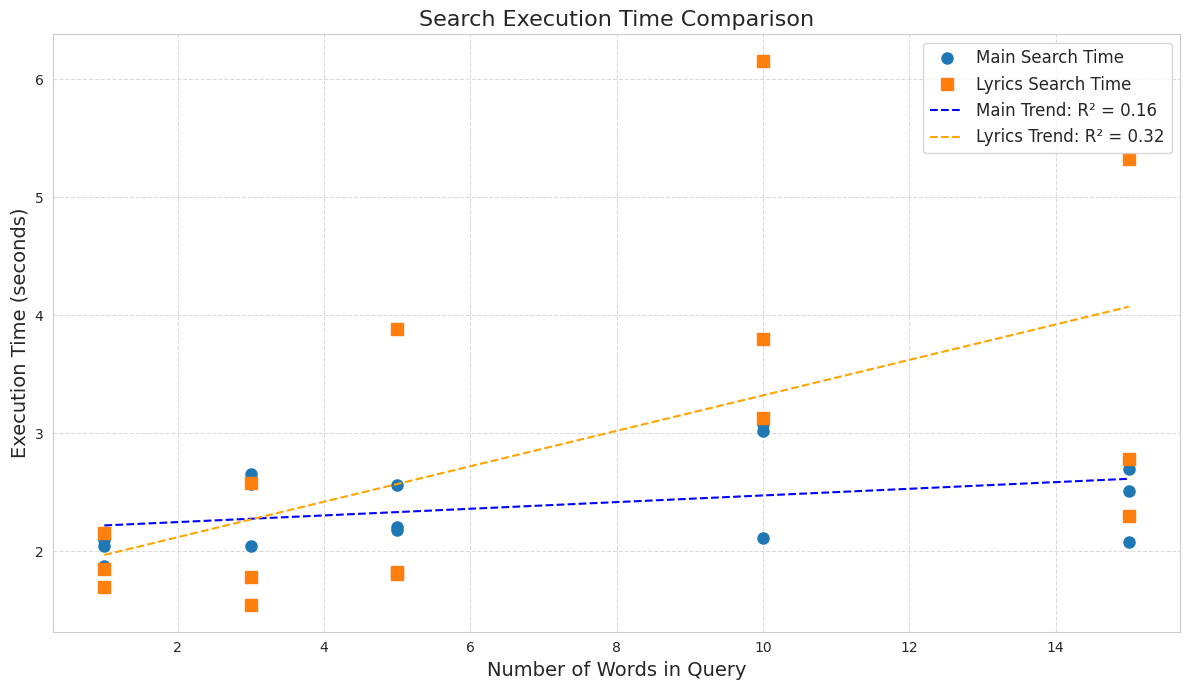

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

def plot_execution_times(time_data):
    # Set the style
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # Create the scatter plot with markers only (no lines)
    plt.plot(time_data['num_words'], time_data['main_time'], 
             marker='o', linestyle='none', markersize=8, label='Main Search Time')
    plt.plot(time_data['num_words'], time_data['lyrics_time'], 
             marker='s', linestyle='none', markersize=8, label='Lyrics Search Time')
    
    # Calculate and add regression lines
    # For main_time
    x = time_data['num_words']
    y_main = time_data['main_time']
    slope_main, intercept_main, r_value_main, p_value_main, std_err_main = stats.linregress(x, y_main)
    r_squared_main = r_value_main**2
    
    # For lyrics_time
    y_lyrics = time_data['lyrics_time']
    slope_lyrics, intercept_lyrics, r_value_lyrics, p_value_lyrics, std_err_lyrics = stats.linregress(x, y_lyrics)
    r_squared_lyrics = r_value_lyrics**2
    
    # Create regression lines
    x_line = np.linspace(min(x), max(x), 100)
    y_main_line = slope_main * x_line + intercept_main
    y_lyrics_line = slope_lyrics * x_line + intercept_lyrics
    
    # Plot regression lines
    plt.plot(x_line, y_main_line, color='blue', linestyle='--', 
             label=f'Main Trend: R² = {r_squared_main:.2f}')
    plt.plot(x_line, y_lyrics_line, color='orange', linestyle='--', 
             label=f'Lyrics Trend: R² = {r_squared_lyrics:.2f}')
        
    # Add titles and labels
    plt.title('Search Execution Time Comparison', fontsize=16)
    plt.xlabel('Number of Words in Query', fontsize=14)
    plt.ylabel('Execution Time (seconds)', fontsize=14)
    plt.legend(fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Use the function with your DataFrame
plot_execution_times(main_time_eval)

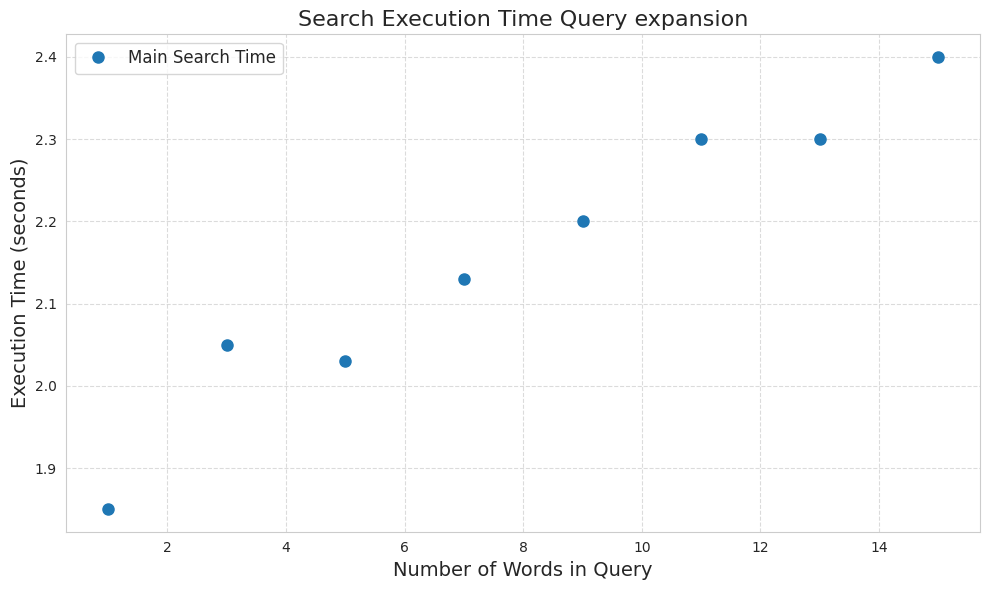

In [71]:
def plot_execution_times_qexpansion(time_data):
    # Set the style
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Create the plot with markers only (no lines)
    plt.plot(time_data['num_words'], time_data['time'], 
             marker='o', linestyle='none', markersize=8, label='Main Search Time')
    
    # Add titles and labels
    plt.title('Search Execution Time Query expansion', fontsize=16)
    plt.xlabel('Number of Words in Query', fontsize=14)
    plt.ylabel('Execution Time (seconds)', fontsize=14)
    plt.legend(fontsize=12)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

plot_execution_times_qexpansion(qexpansion_time_eval)

Query Performance Statistics by Length:


,length,avg_time,min_time,max_time,std_dev,count
0,1,0.146865,0.095303,0.194933,0.049907,3
1,3,0.499765,0.313027,0.683547,0.185278,3
2,5,0.491641,0.338622,0.632157,0.147167,3
3,7,0.770642,0.616029,0.962490,0.176206,3
4,9,1.271936,0.843988,1.501950,0.370961,3


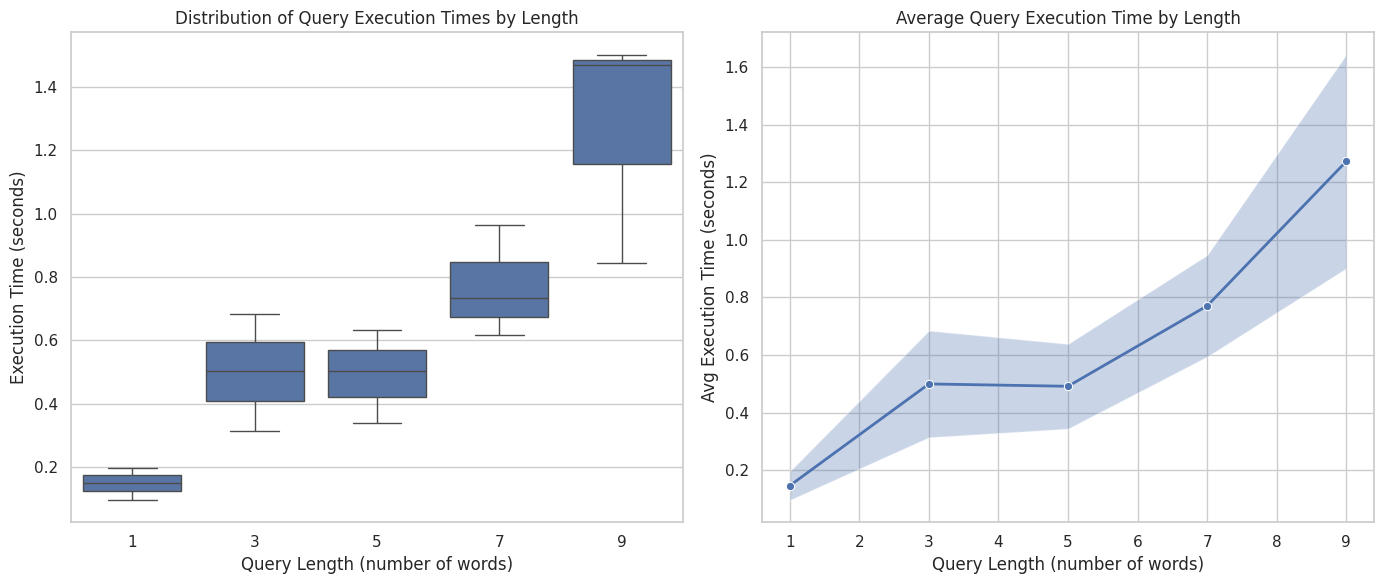


Correlation between query length and execution time: 0.863
P-value: 0.0000 (Significant)

Regression slope: 0.1261 seconds per additional word
Regression intercept: 0.0059 seconds
R² score: 0.745


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from scipy import stats

def evaluate_query_performance(queries: list, time_function=None) -> pd.DataFrame:
    """
    Evaluate query performance based on query length.
    
    Parameters:
    -----------
    queries : List of query strings
    time_function : callable, optional
        Function that takes a query and returns execution time.
        If None, random times will be generated for simulation.
    
    Returns: df with query performance metrics
    """
    # Create results dataframe
    results = []
    
    # If no timing function provided, create a mock one that returns random times
    if time_function is None:
        # Simulate that longer queries take more time with some randomness
        def mock_time_function(query):
            query_length = len(query.split(', '))
            # Base time increases with length, plus some randomness
            return np.random.uniform(0.05, 0.2) * query_length + np.random.uniform(0, 0.1)
        time_function = mock_time_function
    
    # Measure execution time for each query
    for query in queries:
        query_length = len(query.split(', '))
        
        # Measure execution time
        start_time = time()
        execution_time = time_function(query)
        
        results.append({
            'query': query,
            'length': query_length,
            'execution_time': execution_time
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Calculate statistics by query length
    stats_by_length = df.groupby('length').agg(
        avg_time=('execution_time', 'mean'),
        min_time=('execution_time', 'min'),
        max_time=('execution_time', 'max'),
        std_dev=('execution_time', 'std'),
        count=('execution_time', 'count')
    ).reset_index()
    
    return df, stats_by_length

def visualize_query_performance(df, stats_by_length):
    """Visualize query performance metrics"""
    # Set style
    sns.set(style="whitegrid")
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Box plot of execution times by query length
    sns.boxplot(x='length', y='execution_time', data=df, ax=ax1)
    ax1.set_title('Distribution of Query Execution Times by Length')
    ax1.set_xlabel('Query Length (number of words)')
    ax1.set_ylabel('Execution Time (seconds)')
    
    # Plot 2: Line plot of average execution times
    sns.lineplot(x='length', y='avg_time', data=stats_by_length, 
                 marker='o', linewidth=2, ax=ax2)
    ax2.fill_between(stats_by_length['length'], 
                     stats_by_length['avg_time'] - stats_by_length['std_dev'],
                     stats_by_length['avg_time'] + stats_by_length['std_dev'],
                     alpha=0.3)
    ax2.set_title('Average Query Execution Time by Length')
    ax2.set_xlabel('Query Length (number of words)')
    ax2.set_ylabel('Avg Execution Time (seconds)')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Run the evaluation
df_results, query_stats = evaluate_query_performance(test_queries)

# Display statistics table
print("Query Performance Statistics by Length:")
display(query_stats)

# Visualize the results
fig = visualize_query_performance(df_results, query_stats)

# Check if there's a significant correlation between length and execution time
correlation, p_value = stats.pearsonr(df_results['length'], df_results['execution_time'])
print(f"\nCorrelation between query length and execution time: {correlation:.3f}")
print(f"P-value: {p_value:.4f} {'(Significant)' if p_value < 0.05 else '(Not significant)'}")

# Linear regression to quantify the relationship
from sklearn.linear_model import LinearRegression
X = df_results['length'].values.reshape(-1, 1)
y = df_results['execution_time'].values
model = LinearRegression().fit(X, y)
print(f"\nRegression slope: {model.coef_[0]:.4f} seconds per additional word")
print(f"Regression intercept: {model.intercept_:.4f} seconds")
print(f"R² score: {model.score(X, y):.3f}")